## RECANET

TODO:

TOP PERSONAL BASELINE

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

#%cd /content/drive/MyDrive/recsys

Mounted at /content/drive
/content/drive/MyDrive/recsys


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.2)

from IPython.display import clear_output
%matplotlib inline

import pandas as pd
import plotly.express as px
import numpy as np
from tqdm import tqdm

tqdm.pandas()

from sklearn.metrics import accuracy_score, roc_auc_score

import torch
from torch import nn
from torch.utils.data import DataLoader
#from torchvision import datasets, transforms

import torch.nn.functional as F
import torch.optim as optim
#import torchvision.transforms as tt

from tqdm.notebook import tqdm
from torchsummary import summary


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [4]:
!nvidia-smi

Sun Jan 22 22:18:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    28W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Dataloader+dataset

In [5]:
history_len=20
item_embed_size=128
user_embed_size=32

h1 = 128
h2 = 128
h3 = 128
h4 = 128
h5 = 128

In [6]:
from metrics import recall_k, ndcg_k, repeat_score_item, repeat_score_user
from recanet_datasets import PreDataset, RCNDataset, DeviceDataLoader
from recanet_model import ReCaNet

In [7]:
path_train = 'dunnhumby_cj/baskets/train_baskets_sample.csv'
path_test = 'dunnhumby_cj/baskets/test_baskets.csv'
path_val = 'dunnhumby_cj/baskets/valid_baskets.csv'

In [8]:
dataset = PreDataset(path_train,path_val, path_test, dataset='dunnhumby', history_len=history_len,basket_count_min=3, min_item_count = 5)

number of test users: 981
filtered items: 5078
items: 22924
filtered items: 5078


In [9]:
#train_items,train_users, train_history,train_history2 ,train_labels = dataset.create_train_data()
#train_labels.unique(return_counts=True)

Data allready in use


In [10]:
#train_items.shape,train_users.shape, train_history.shape,train_history2.shape

((409970,), (409970,), (409970, 20), (409970, 20))

In [11]:
batch_size = 10000

train_dataset = RCNDataset(dataset, mode='train')
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = RCNDataset(dataset, mode='val')
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

test_dataset = RCNDataset(dataset, mode='test')
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Data allready in use


In [12]:
len(train_loader.dataset), len(val_loader.dataset), len(test_loader.dataset)

(409970, 26546, 29317)

In [13]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [15]:
#summary(ReCaNet(num_items=duhumby.num_items, item_embed_size=32, num_users=duhumby.num_users, user_embed_size=128,\
#                h1 = 128,h2 = 128,h3 = 128,h4 = 128,h5 = 128).to(device), \
#       input_size=[ (None,1), (None,1), (None, 5), (None, 5)], device=device)

## Train pipeline

In [16]:
def plot_training(loss_train, loss_val, score_test ,i):
    plt.figure(figsize=(16, 3))
    plt.plot(np.arange(i+1), loss_train, label='Train')
    plt.plot(np.arange(i+1), loss_val, label='Validation')
    plt.xlim(0, i+2)
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
        
    plt.figure(figsize=(16, 3))
    plt.plot(np.arange(i+1), score_test, label='roc_auc_score')
    plt.xlim(0, i+2)
    plt.ylim(0, 1)
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.show()

In [17]:
torch.cuda.empty_cache()

In [18]:
def train(model, epochs):
    torch.cuda.empty_cache()
    #clear_output(wait=True)
    loss_train = []
    loss_val = []
    auc_test = []

    recall_score = []

    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=0.001)
    criterion = nn.BCELoss(reduction='mean')

    user_valid_baskets_df = dataset.valid_baskets.groupby('user_id')['item_id'].apply(list).reset_index()
    user_valid_baskets_dict = dict(zip( user_valid_baskets_df['user_id'],user_valid_baskets_df['item_id']))
    test_items, test_users, test_history,test_history2, test_labels = dataset.create_test_data('test')
    valid_items, valid_users, valid_history,valid_history2 ,valid_labels = dataset.create_test_data('valid')

    
    for i in tqdm(range(epochs)):
        print(f'Epoch {i}')
        loss_train_epoch = []
        loss_val_epoch = []
        acc_val_epoch = []

        model.train()
        for x1, x2, x3, x4, y in tqdm(train_loader):
            optimizer.zero_grad()
            y_pred = model(x1, x2, x3, x4)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            loss_train_epoch.append(loss.item())
        
        loss_train.append(np.mean(loss_train_epoch))
        #print(loss_train)
        #print(np.arange(i+1))
        #model.eval()
        
        full_y = []
        full_predictions = []
        pred_scores = []
        for x1, x2, x3, x4, y in val_loader:
            with torch.no_grad():
                y_pred = model(x1, x2, x3, x4)
                loss = criterion(y_pred, y)

                predictions = [round(value) for value in y_pred.flatten().tolist()]
                full_y.extend(y.detach().cpu())
                pred_scores.extend(y_pred.detach().cpu())
                full_predictions.extend(predictions)

                loss_val_epoch.append(loss.item())
                auc_val_epoch = roc_auc_score(y.cpu(), y_pred.cpu())

        accuracy = accuracy_score(full_y, full_predictions)
        print("Accuracy epoch: %.2f%%" % (accuracy * 100.0))

        #recall_score.append(epoch_recall(model, y_true=full_y ,y_pred=pred_scores, predictions=full_predictions))

        loss_val.append(np.mean(loss_val_epoch))
                
        auc_test.append(np.mean(auc_val_epoch))

        # отрисовка графиков
        #clear_output(wait=True)
        plot_training(loss_train, loss_val, score_test=auc_test, i=i)

    print(recall_score)
    #print('Best epoch:', np.argmax(np.array(recall_score))) 
    return loss_train, loss_val
     

In [19]:
def epoch_recall(model, y_true ,y_pred, predictions):
    recall_scores = []
    for user in user_valid_baskets_dict:
        top_items = []
        if user in dataset.user_id_mapper:
            user_id = dataset.user_id_mapper[user]
            indices = np.argwhere(valid_users == user_id)
            item_scores = np.array(y_pred)[indices].flatten()
            item_ids = valid_items[indices].flatten()

            item_score_dic = {}
            for i, item_id in enumerate(item_ids):
                item_score_dic[dataset.id_item_mapper[item_id]] = item_scores[i]
            sorted_item_scores = sorted(item_score_dic.items(), key= lambda x: x[1], reverse = True)
            top_items = [x[0] for x in sorted_item_scores]
        recall_scores.append(recall_k(user_valid_baskets_dict[user],top_items,
                                              len(user_valid_baskets_dict[user])))
            
    return np.mean(recall_scores)

In [70]:
model = ReCaNet(num_items=dataset.num_items, item_embed_size=item_embed_size, num_users=dataset.num_users, 
                user_embed_size=user_embed_size, history_len = history_len, h1 = h1,h2 = h2, h3 = h3,
                h4 = h4, h5 = h5).to(device)

In [71]:
# from torchsummary import summary
#summary(ReCaNet(num_items=dataset.num_items, item_embed_size=32, history_len=20, num_users=dataset.num_users, user_embed_size=128,\
#               h1 = 128,h2 = 128,h3 = 128,h4 = 128,h5 = 128).to(device), \
#       input_size=[(None,1), (None,1), (None, 5), (None, 5)], device=device)

In [72]:
model

ReCaNet(
  (item_embedding): Embedding(5079, 128)
  (user_embedding): Embedding(1499, 32)
  (fc1): Linear(in_features=160, out_features=128, bias=True)
  (fc2): Linear(in_features=129, out_features=128, bias=True)
  (lstm1): LSTM(128, 128, batch_first=True)
  (lstm2): LSTM(128, 128, batch_first=True)
  (fc5): Linear(in_features=128, out_features=128, bias=True)
  (fc6): Linear(in_features=128, out_features=128, bias=True)
  (fc7): Linear(in_features=128, out_features=1, bias=True)
)

In [73]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

+-----------------------+------------+
|        Modules        | Parameters |
+-----------------------+------------+
| item_embedding.weight |   650112   |
| user_embedding.weight |   47968    |
|       fc1.weight      |   20480    |
|        fc1.bias       |    128     |
|       fc2.weight      |   16512    |
|        fc2.bias       |    128     |
|   lstm1.weight_ih_l0  |   65536    |
|   lstm1.weight_hh_l0  |   65536    |
|    lstm1.bias_ih_l0   |    512     |
|    lstm1.bias_hh_l0   |    512     |
|   lstm2.weight_ih_l0  |   65536    |
|   lstm2.weight_hh_l0  |   65536    |
|    lstm2.bias_ih_l0   |    512     |
|    lstm2.bias_hh_l0   |    512     |
|       fc5.weight      |   16384    |
|        fc5.bias       |    128     |
|       fc6.weight      |   16384    |
|        fc6.bias       |    128     |
|       fc7.weight      |    128     |
|        fc7.bias       |     1      |
+-----------------------+------------+
Total Trainable Params: 1032673


1032673

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1


  0%|          | 0/41 [00:00<?, ?it/s]

Accuracy epoch: 97.63%


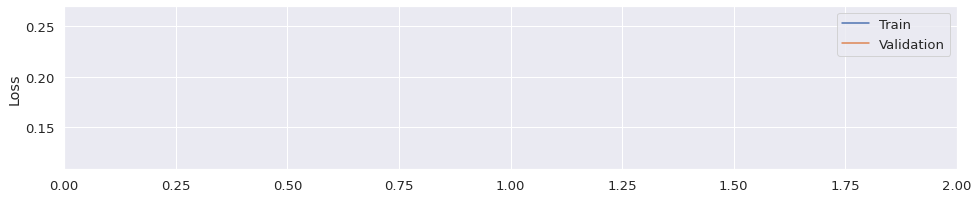

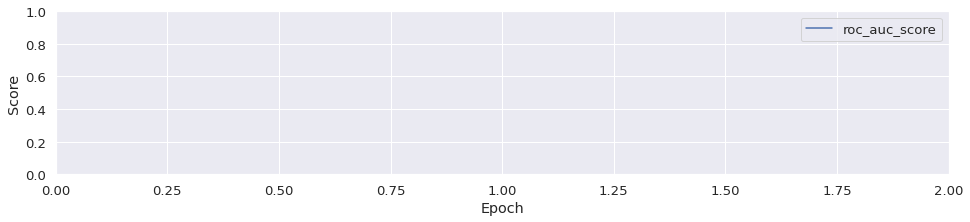

Epoch 2


  0%|          | 0/41 [00:00<?, ?it/s]

Accuracy epoch: 97.63%


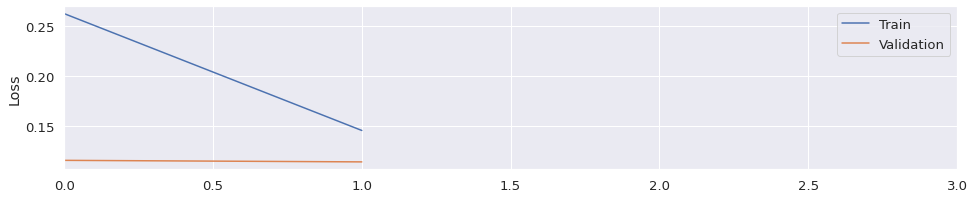

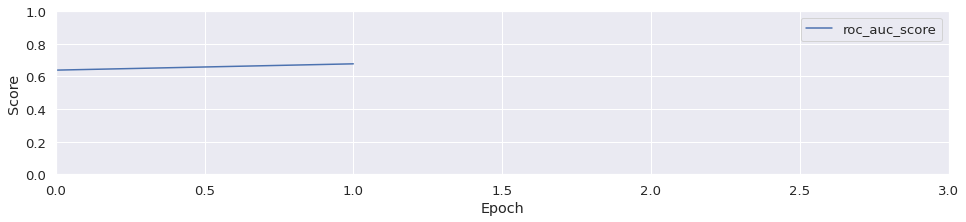

Epoch 3


  0%|          | 0/41 [00:00<?, ?it/s]

Accuracy epoch: 97.63%


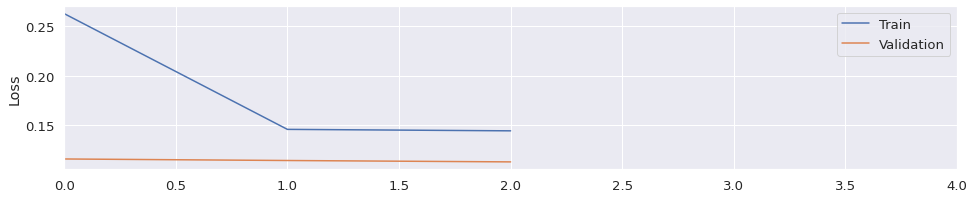

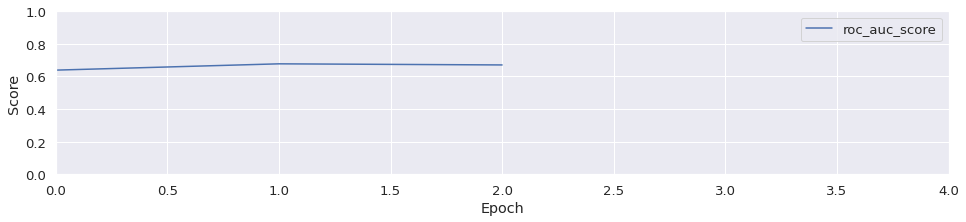

Epoch 4


  0%|          | 0/41 [00:00<?, ?it/s]

Accuracy epoch: 97.63%


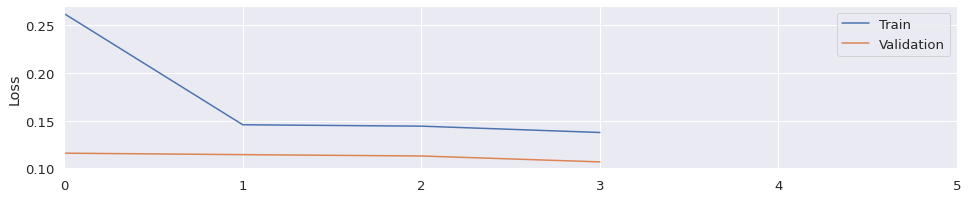

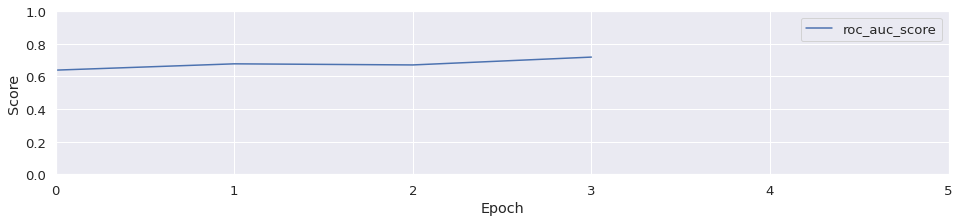

Epoch 5


  0%|          | 0/41 [00:00<?, ?it/s]

Accuracy epoch: 97.63%


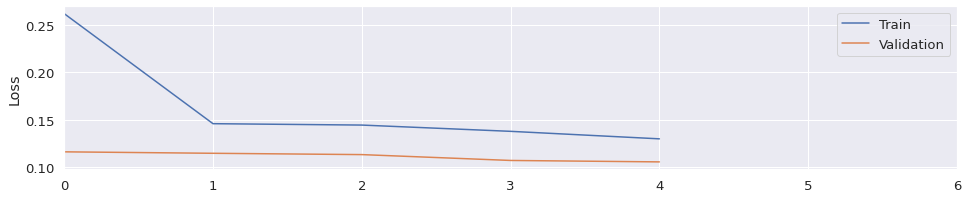

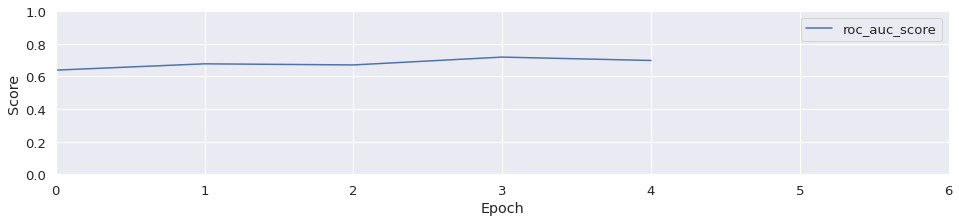

Epoch 6


  0%|          | 0/41 [00:00<?, ?it/s]

Accuracy epoch: 97.63%


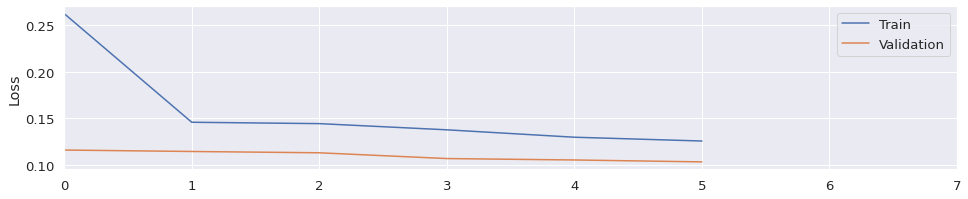

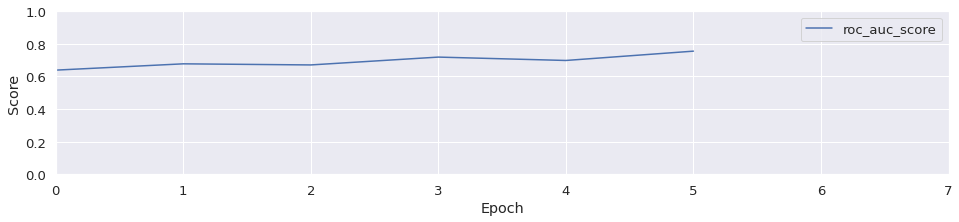

Epoch 7


  0%|          | 0/41 [00:00<?, ?it/s]

Accuracy epoch: 97.63%


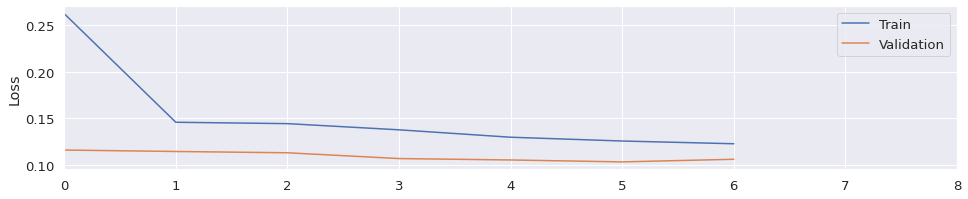

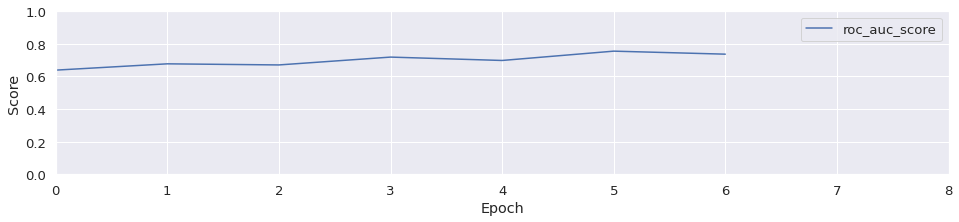

Epoch 8


  0%|          | 0/41 [00:00<?, ?it/s]

Accuracy epoch: 97.63%


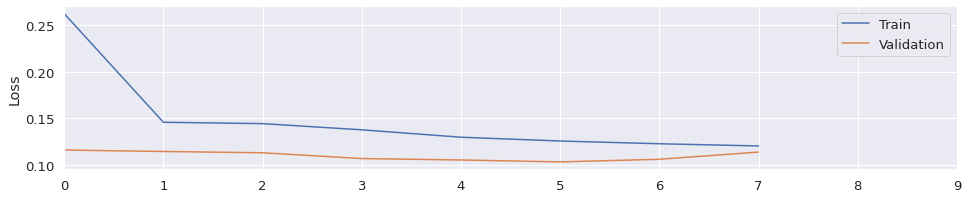

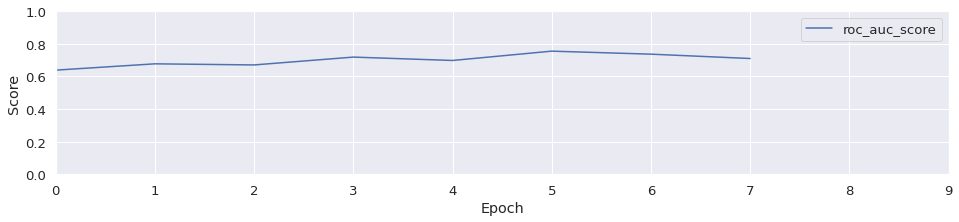

Epoch 9


  0%|          | 0/41 [00:00<?, ?it/s]

Accuracy epoch: 97.63%


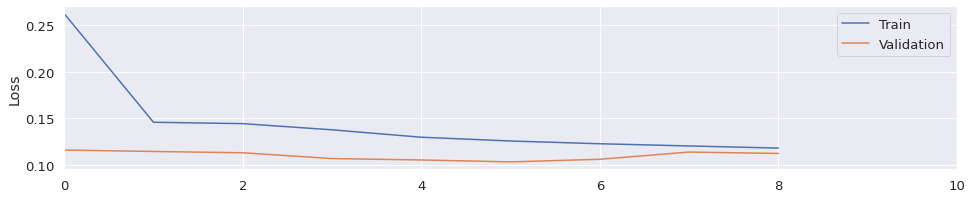

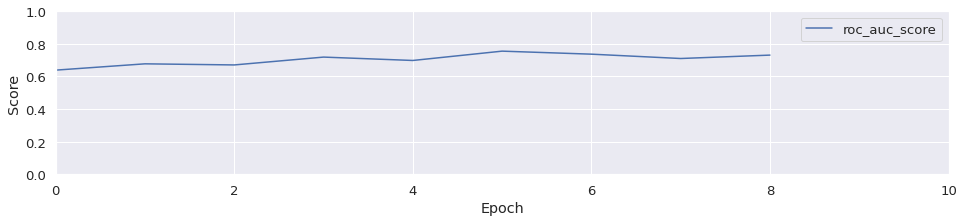

Epoch 10


  0%|          | 0/41 [00:00<?, ?it/s]

Accuracy epoch: 97.63%


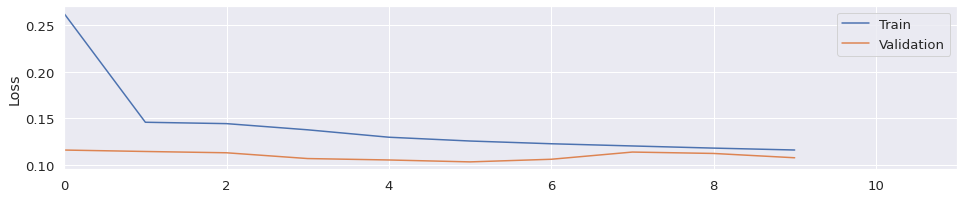

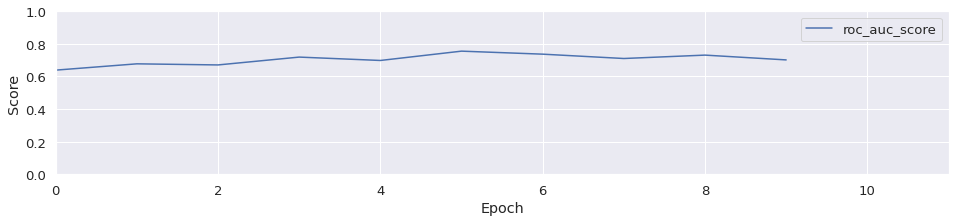

[]


In [74]:
info = train(model, epochs=10)

## Prediction

In [75]:
def predict(model, test_loader):
    test_items, test_users, test_history,test_history2, test_labels = dataset.create_test_data('test')
    preds = []
    pred_scores = []
    for x1, x2, x3, x4, y in tqdm(test_loader):
        with torch.no_grad():
            y_pred = model(x1, x2, x3, x4)
            pred = [round(value) for value in y_pred.flatten().tolist()]
            preds.extend(pred)
            pred_scores.extend(y_pred.flatten().tolist())
            
   
    prediction_baskets = {}
    prediction_scores = {}
    for user in dataset.test_users:
        top_items = []
        if user in dataset.user_id_mapper:
            user_id = dataset.user_id_mapper[user]
            indices = np.argwhere(test_users == user_id)
            item_scores = np.array(pred_scores)[indices].flatten()
            item_ids = test_items[indices].flatten()
            item_score_dic = {}
            for i, item_id in enumerate(item_ids):
                item_score_dic[dataset.id_item_mapper[item_id]] = item_scores[i]
            sorted_item_scores = sorted(item_score_dic.items(), key= lambda x: x[1], reverse = True)
            top_items = [x[0] for x in sorted_item_scores]
            prediction_scores[user] = sorted_item_scores
            
        prediction_baskets[user] = top_items

    return prediction_baskets

In [76]:
test_baskets = pd.read_csv(path_test)
user_test_baskets_df = test_baskets.groupby('user_id')['item_id'].apply(list).reset_index()
user_test_baskets_dict = dict(zip( user_test_baskets_df['user_id'],user_test_baskets_df['item_id']))

user_predictions = predict(model, test_loader)
final_users = set(dataset.test_users).intersection(set(list(user_test_baskets_dict.keys())))
print('predictions ready',len(user_predictions))
print('number of final test users:',len(final_users))
for k in [5,10,20,'B']:
    print(k)
    recall_scores = {}
    ndcg_scores = {}
    zero = 0
    for user in final_users:

        top_items = []
        if user in user_predictions:
            top_items = user_predictions[user]
        else:
            zero+=1

        if k == 'B':
            recall_scores[user] = recall_k(user_test_baskets_dict[user],top_items,len(user_test_baskets_dict[user]))
            ndcg_scores[user] = ndcg_k(user_test_baskets_dict[user],top_items,len(user_test_baskets_dict[user]))
        else:
            recall_scores[user] = recall_k(user_test_baskets_dict[user],top_items,k)
            ndcg_scores[user] = ndcg_k(user_test_baskets_dict[user],top_items,k)
    #print(zero)
    print('recall:',np.mean(list(recall_scores.values())))
    print('ndcg:',np.mean(list(ndcg_scores.values())))

  0%|          | 0/3 [00:00<?, ?it/s]

predictions ready 981
number of final test users: 481
5
recall: 0.024058172442419937
ndcg: 0.027680730756114307
10
recall: 0.033010955814091775
ndcg: 0.024985089419441324
20
recall: 0.04883644671169801
ndcg: 0.02329878353178997
B
recall: 0.02575749437197789
ndcg: 0.0258819102400303
